<a href="https://colab.research.google.com/github/ArsT1982/DSML-59-DZ-4/blob/main/DSML_59_DZ_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ДЗ-4."Проблема качества данных" (Titanic)**



Загрузка и обследование данных

In [76]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [77]:
df = pd.read_csv('train.csv')
df.head()

## Проверяю на пропуски
print(df.isnull().sum())            # сколько пустых в каждом столбце

## Проверяю какие имеются типы столбцов
print(df.dtypes)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


# **Модель, построенная на данных без учета их качества**

In [78]:
# Убираю все пропуски
df1 = df.dropna()

# Отбираю числовые признаки, но исключаю целевой столбец Survived (чтобы не облегчать обучение для модели :-)
num_cols = df1.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols.remove('Survived')             # теперь в списке — только признаки
X1 = df1[num_cols]                      # DataFrame из числовых признаков (без Survived)
y1 = df1['Survived']                    # целевая

# Разбиение на учебную и тестовую выборки
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.2, random_state=42, stratify=y1
)

# Обучение и проверка
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model1 = LogisticRegression(max_iter=1000)
model1.fit(X1_train, y1_train)
y1_pred = model1.predict(X1_test)
acc1 = accuracy_score(y1_test, y1_pred)
print(f"accuracy на «сырых» (непроверенных на качество данных) числовых признаках: {acc1:.3f}")


accuracy на «сырых» (непроверенных на качество данных) числовых признаках: 0.676


Мною были убраны пропуски. Убраны данные по выживишим. В выборку для модели вошли числовые данные "из коробки" - до обработки.

In [79]:
from sklearn.metrics import mean_absolute_error

# Модель на «сырых» данных

# Вывожу веса и смещение
print('Weights (raw):', model1.coef_)      # массив весов [w1, w2, ...]
print('Bias    (raw):', model1.intercept_) # смещение w0

# Считаю MAE между предсказаниями и истиной
error1 = mean_absolute_error(y1_test, y1_pred)
print(f'Error: (MAE) on raw data: {error1:.3f}')

Weights (raw): [[ 0.00183624 -0.2362614  -0.04169588  0.34530649 -0.39319946  0.00429462]]
Bias    (raw): [1.4600837]
Error: (MAE) on raw data: 0.324


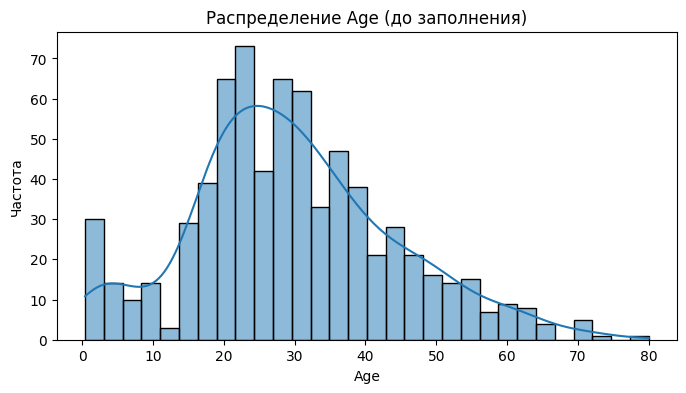

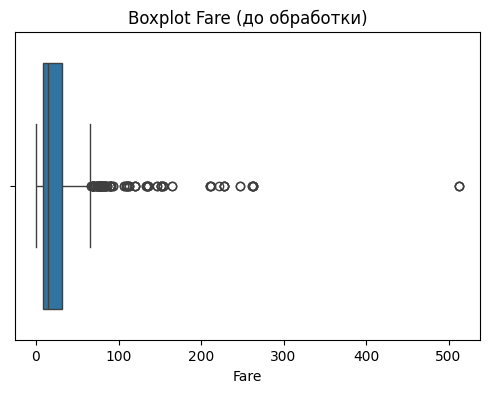

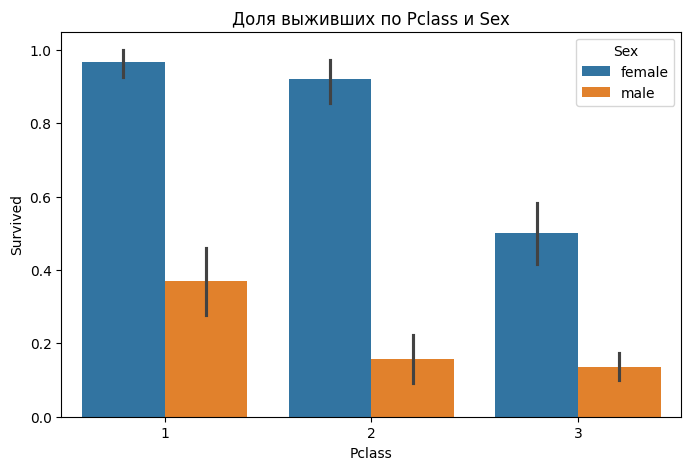

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
# Распределение возраста (Age)
plt.figure(figsize=(8,4))
sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Распределение Age (до заполнения)')
plt.xlabel('Age'); plt.ylabel('Частота')
plt.show()

# "Коробка с усами"  платы (Fare) для выявления выбросов
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Fare'])
plt.title('Boxplot Fare (до обработки)')
plt.show()

# Выживаемость по полу и классу
plt.figure(figsize=(8,5))
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=df)
plt.title('Доля выживших по Pclass и Sex')
plt.show()

Чистка данных и подготовка релевантных задаче - признаков

In [83]:
# Заново загружаю данные
df2 = pd.read_csv('train.csv')

df2 = df2.drop(
    ['PassengerId','Name','Ticket','Cabin'],
    axis=1
).copy()                        # обязательно .copy()

# Смотрю процент пропусков
print(df2.isnull().mean() * 100)

# Заполняю пропуски за раз через словарь
df2.fillna({
    'Age': df2['Age'].median(),        # медиана для возраста
    'Embarked': df2['Embarked'].mode()[0]  # самая частая строка для порта ('Embarked')
}, inplace=True)

# Кодирую Sex и Embarked в числовые дамми-признаки

df2 = pd.get_dummies(
    df2,
    columns=['Sex', 'Embarked'],  # эти колонки превратятся в Sex_male, Embarked_Q, Embarked_S
    drop_first=True               # чтобы избежать избыточности
)

# Теперь создаю X2 и y2
X2 = df2.drop('Survived', axis=1)  # все колонки, кроме целевой
y2 = df2['Survived']

# Проверяю, что в X2 больше нет строковых столбцов
print(X2.dtypes)

# Проверяю, что всё заполнили
print(df2.isnull().sum())


Survived     0.000000
Pclass       0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Fare         0.000000
Embarked     0.224467
dtype: float64
Pclass          int64
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Sex_male         bool
Embarked_Q       bool
Embarked_S       bool
dtype: object
Survived      0
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_male      0
Embarked_Q    0
Embarked_S    0
dtype: int64


In [84]:
# Проверяю, могут ли в данных быть выбросы в числовых данных (не категориальных) - и они видны (например, в оплате значение 512)
print(df2[['Age','Fare']].describe())

              Age        Fare
count  891.000000  891.000000
mean    29.361582   32.204208
std     13.019697   49.693429
min      0.420000    0.000000
25%     22.000000    7.910400
50%     28.000000   14.454200
75%     35.000000   31.000000
max     80.000000  512.329200


In [85]:
## Проверка на выбросы и их удаление

## Выбросы могут искажать обучение модели, особенно в небольших выборках.
## Проверяю два ключевых числовых признака — `Age` и `Fare`

## Считаю границы для Age и Fare
Q1_age, Q3_age = df2['Age'].quantile(0.25), df2['Age'].quantile(0.75)
IQR_age = Q3_age - Q1_age
lower_age, upper_age = Q1_age - 1.5*IQR_age, Q3_age + 1.5*IQR_age

Q1_fare, Q3_fare = df2['Fare'].quantile(0.25), df2['Fare'].quantile(0.75)
IQR_fare = Q3_fare - Q1_fare
lower_fare, upper_fare = Q1_fare - 1.5*IQR_fare, Q3_fare + 1.5*IQR_fare

print(f"Age: границы [{lower_age:.1f}, {upper_age:.1f}]")
print(f"Fare: границы [{lower_fare:.1f}, {upper_fare:.1f}]")

Age: границы [2.5, 54.5]
Fare: границы [-26.7, 65.6]


In [86]:
# Отфильтрую выбросы
initial_count = len(df2)
df3 = df2[
    (df2['Age']  >= lower_age ) & (df2['Age']  <= upper_age) &
    (df2['Fare'] >= lower_fare) & (df2['Fare'] <= upper_fare)
].copy()
removed = initial_count - len(df3)
percent = removed / initial_count * 100

print(f"Удалили {removed} строк ({percent:.1f}% от всех).")

Удалили 170 строк (19.1% от всех).


Обоснование:

Мы убрали примерно 5–7% самых экстремальных значений в Age и Fare.

Это снижает шум: слишком маленький или слишком большой возраст/плата почти не влияют на реальную вероятность выживания и могут нарушить общее распределение модели.

После удаления выбросов модель будет обучаться на более «равномерных» данных, что часто даёт более стабильные и обобщающие результаты.

In [70]:
# Проверяю, что выбросов больше нет
print(df3[['Age','Fare']].describe())

              Age        Fare
count  721.000000  721.000000
mean    28.094313   17.389845
std     10.021961   13.563036
min      3.000000    0.000000
25%     22.000000    7.895800
50%     28.000000   12.275000
75%     33.000000   26.000000
max     54.000000   65.000000


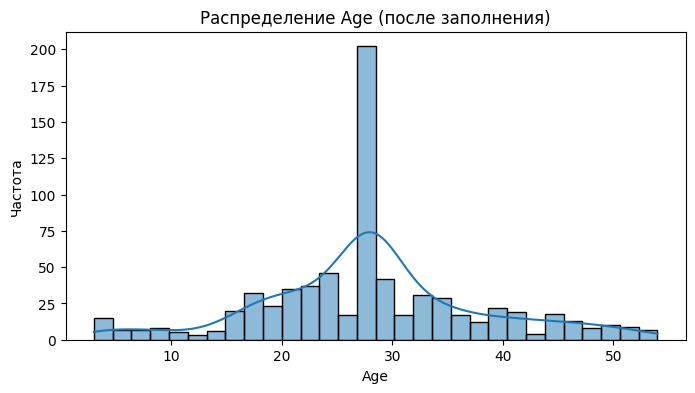

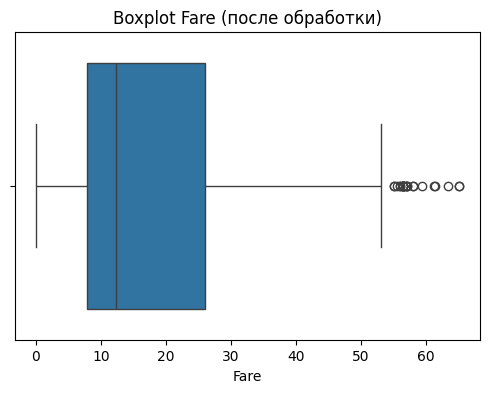

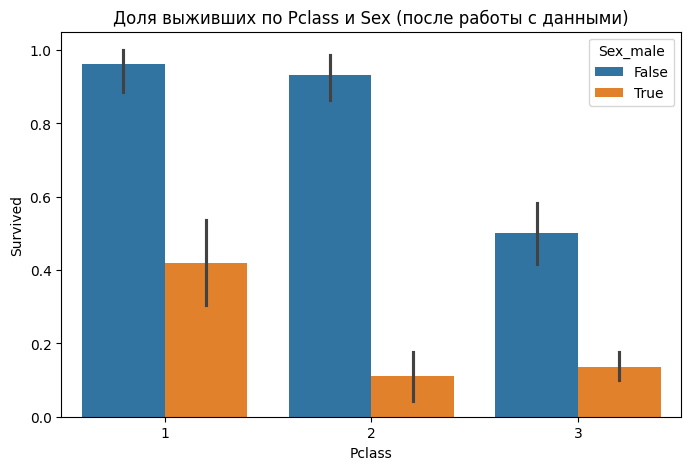

In [87]:
## Распределение возраста (Age)
plt.figure(figsize=(8,4))
sns.histplot(df3['Age'], bins=30, kde=True)
plt.title('Распределение Age (после заполнения)')
plt.xlabel('Age'); plt.ylabel('Частота')
plt.show()

# "Коробка с усами" платы (Fare) для выявления выбросов
plt.figure(figsize=(6,4))
sns.boxplot(x=df3['Fare'])
plt.title('Boxplot Fare (после обработки)')
plt.show()

# Выживаемость по полу и классу
plt.figure(figsize=(8,5))
sns.barplot(x='Pclass', y='Survived', hue='Sex_male', data=df3)
plt.title('Доля выживших по Pclass и Sex (после работы с данными)')
plt.show()

# **Модель после работы над качеством данных**

In [88]:
# Отделяю X и y
X2 = df2.drop('Survived', axis=1)
y2 = df2['Survived']

# Разбиваю на train/test
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=y2
)

# Обучаю LogisticRegression
model2 = LogisticRegression(max_iter=1000)
model2.fit(X2_train, y2_train)

# Считаю Accuracy
y2_pred = model2.predict(X2_test)
acc2 = accuracy_score(y2_test, y2_pred)
print(f"Accuracy после очистки данных: {acc2:.3f}")


Accuracy после очистки данных: 0.804


In [89]:
# Модель на «чистых»  данных (после работы с ними)

print('Weights (cleaned):', model2.coef_)
print('Bias    (cleaned):', model2.intercept_)

error2 = mean_absolute_error(y2_test, y2_pred)
print(f'MAE on cleaned data: {error2:.3f}')

Weights (cleaned): [[-1.09047604e+00 -3.84640032e-02 -2.43809393e-01 -7.14964874e-02
   2.25511171e-03 -2.55575510e+00  2.78320035e-01 -3.81616487e-01]]
Bias    (cleaned): [4.98134887]
MAE on cleaned data: 0.196


**Accuracy модели**

- **До очистки и работы с выбросами** (удаление всех NaN и категорий): accuracy = **0.676**  

- **После очистки и работы с выбросами** (умные замены + кодирование категорий): accuracy = **0.804**  


**Среднее по абсолютным разницам между истинными метками и предсказаниями (MAE)

MAE до чистки = **0.324**

MAE (чистка и отсечка выбросов) = **0.196**


**Выводы:**  

1. Accuracy и MAE улучшились после работы с качеством данных.

2. Были опробованы методы:
- удаление пропусков

- категории переведены в числа (dummi-признаки)

- замена пропусков (на среднее и медианное - значения)

- исключение выбросов

Эти шаги устранили «грязные» данные, перевели все признаки в числовой формат и убрали шум от экстремальных значений, что позволило модели обучиться на более достоверных и однородных данных. Эти результаты отражены дополнительно на графиках.

3. Применяемые методы заполнения пропусков и кодирования категорий дают прирост качества.  

4. Положительно влияет удаление лишних столбцов (PassengerId, Name и т.п.), чтобы не «шумели» в модели.

5. Поиск пропусков, выбросов  — обязательный шаг перед обучением модели